In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import soundfile as sf
import librosa
from librosa.display import specshow
import pandas as pd


from argparse import ArgumentParser
import random, sys, math, gzip, os
from tqdm import tqdm
import random, sys, math, gzip, os
import json
from tqdm import tqdm
from IPython.display import Audio 
import IPython
import soundfile 
import copy
import datetime

sys.path.append('../')
from dataloader.nsynthdataset import NSynthDataSet
from util import util
from transformer.transformers import GTransformer

%load_ext autoreload
%autoreload 2

np.seterr(divide='ignore', invalid='ignore')
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [2]:
config = util.get_config('../config/config-emb512.json')
data_dir = config['data_dir']
sample_rate = config['sample_rate']
batch_size = config['batch_size']
lr = config['lr']
lr_warmup = config['lr_warmup']
epochs = config['epochs']

sample_length = config['sample_length']
embedding_size = config['embedding_size'] 
num_heads = config['num_heads']
depth = config['depth']
num_tokens = config['num_tokens']

lower_pitch_limit = config['lower_pitch_limit']
upper_pitch_limit = config['upper_pitch_limit']

In [3]:
model_interp = GTransformer(emb=embedding_size, heads=num_heads, depth=depth, seq_length=sample_length, num_tokens=num_tokens, attention_type=None)
model_interp = model_interp.cuda()

opt_interp = torch.optim.Adam(lr=lr, params=model_interp.parameters())
sch_interp = torch.optim.lr_scheduler.LambdaLR(opt_interp, lambda i: min(i / (lr_warmup / batch_size), 1.0))
loss_interp = torch.nn.NLLLoss(reduction='mean')

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model_interp)

12805376

In [5]:
print(model_interp)

GTransformer(
  (token_embedding): Linear(in_features=4, out_features=512, bias=True)
  (token_embedding_batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (token_embedding_activation): ReLU()
  (pos_embedding): Linear(in_features=128, out_features=512, bias=True)
  (pos_embedding_batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (pos_embedding_activation): ReLU()
  (tblocks): Sequential(
    (0): TransformerBlock(
      (attention): SelfAttention(
        (tokeys): Linear(in_features=512, out_features=512, bias=False)
        (toqueries): Linear(in_features=512, out_features=512, bias=False)
        (tovalues): Linear(in_features=512, out_features=512, bias=False)
        (unifyheads): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ff): Se

In [6]:
def load_model(model, opt, model_location):
    checkpoint = torch.load(model_location)
    model.load_state_dict(checkpoint['model_state_dict'])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])
    loss = checkpoint['loss']
    epoch = checkpoint['epoch']
    return model, opt, loss, epoch

def mulawEncodeInput(inputd):
    inputd = (librosa.mu_compress(inputd, quantize=False) + 1)/2
    return inputd

def mulawDecodeInput(output):
    output = (output * 2) - 1
    waveform = librosa.mu_expand(output, quantize=False)
    return waveform

def mulawEncodeTarget(inputd):
    target = librosa.mu_compress(inputd, quantize=True) + 127
    target = target.astype(np.long)
    return target

def mulawDecodeTarget(output):
    output = output - 127
    waveform = librosa.mu_expand(output, quantize=True)
    return waveform

def get_scaled_pitch(pitch):
    return (pitch - lower_pitch_limit)/(upper_pitch_limit - lower_pitch_limit)

In [7]:
def get_data(idx, start_location):
    input_data = np.array([])
    audio_data = np.array([])
    
    print(idx)
    if idx == 'random':
        input_data = np.random.rand((sample_length)) * 0.1
        audio_data = input_data
        target = np.random.rand((sample_length))
    else:
        start_location = int(start_location * 16000)

        audio_file_name = os.path.join(data_dir, idx+'.wav')
        audio_data, _ = librosa.load(audio_file_name, sr=sample_rate)
        input_data = audio_data[start_location:start_location + sample_length]
        target = audio_data[start_location + 1:start_location + 1 + sample_length]

        
    IPython.display.display(IPython.display.Audio(audio_data, rate=sample_rate))
    
    fig, axes = plt.subplots(ncols=2, figsize=(8,4))
    axes[0].plot(audio_data)
    axes[0].set(title='Sample Length = 64000/4 secs')
    axes[1].plot(input_data)
    axes[1].set(title='Sample Length = 512/32 ms')
    
    plt.show()
    
    return input_data, target

In [8]:
def sample_model_amplitude_interpolation(seed_id, model_interp, start_location=1.0, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=1024, interpolation_type='step'):
    seed, seed_target = get_data(seed_id, start_location)

    new_scale = amplitude_scale
    
    start_time = datetime.datetime.now().replace(microsecond=0)
    orig_waveform = copy.copy(seed)

    input_data = mulawEncodeInput(copy.copy(seed))
    final_sample_data = torch.from_numpy(copy.copy(input_data)).view(1, -1).cuda()
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(pitch)]), input_data.shape)
    scale = np.broadcast_to(np.array([new_scale]), input_data.shape)
    instrument = np.broadcast_to(np.array([instrument_id]), input_data.shape)
    input_data = np.stack((input_pitch, scale, instrument, input_data), axis=1)
    input_data = torch.from_numpy(input_data).cuda()
    
    model_interp.eval()
    
    new_scale_arr = np.array([new_scale])
    
    # 1. Sample from model
    with torch.no_grad():
        for ind in range(seq_len):
            input_data = input_data.view(1, -1, 4).float() #Convert to batch_size X seq_len X 2
            sample_data = model_interp(input_data) #Output is batch_size X seq_length X one_hot len (256) i.e. 1 X 512 X 256. 
            
            sample_data = sample_data[0, -1, :].argmax() #Get the last sample probabilities and argmax.
            
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            sample_data = (librosa.mu_compress(sample_data, quantize=False) + 1)/2 #Just like what we do in NSynthDataSet_RawAudio.py
            sample_data = torch.from_numpy(sample_data).view(1,-1).cuda()
            
            
            final_sample_data = torch.cat((final_sample_data, sample_data), dim=1)
            input_data = final_sample_data[:,final_sample_data.shape[1]-sample_length:].view(1,-1)
    
            if interpolation_type == 'triangles':
                
                count = ind%(seq_len)
                
                if count <= (seq_len//2):
                    new_scale = new_scale + (0.9-amplitude_scale)/(seq_len//2)
                elif count > (seq_len//2):
                    new_scale = new_scale - (0.9-amplitude_scale)/(seq_len//2)
                
                new_scale_arr = np.append(new_scale_arr, new_scale)
                
                scale = np.broadcast_to(np.array([new_scale]), input_data.shape)
            
            input_data = torch.cat((torch.from_numpy(input_pitch).view(1,-1).cuda(),\
                                    torch.from_numpy(scale).view(1, -1).cuda(),\
                                    torch.from_numpy(instrument).view(1, -1).cuda(),\
                                    input_data), dim=0)
            input_data = input_data.T
#             print('3', input_data)
            
    
    final_sample_data = final_sample_data.view(-1).cpu().numpy()
#     print(final_sample_data)
    waveform = mulawDecodeInput(final_sample_data)
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(orig_waveform, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(waveform, rate=sample_rate))
    
    # 3. Plot waveforms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(orig_waveform)
    axes[0].set_title('Original Seed')

    axes[1].plot(waveform[sample_length:])
    axes[1].plot(new_scale_arr)
    axes[1].set_title('New Sample')
    plt.show()
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)
    return waveform, orig_waveform

In [9]:
def sample_model_instrument_interpolation(seed_id, model_interp, start_location=1.0, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=1024, interpolation_type='step'):
    seed, seed_target = get_data(seed_id, start_location)

    new_instrument_id = 0.0
    
    start_time = datetime.datetime.now().replace(microsecond=0)
    orig_waveform = copy.copy(seed)

    input_data = mulawEncodeInput(copy.copy(seed))
    final_sample_data = torch.from_numpy(copy.copy(input_data)).view(1, -1).cuda()
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(pitch)]), input_data.shape)
    scale = np.broadcast_to(np.array([amplitude_scale]), input_data.shape)
    instrument = np.broadcast_to(np.array([new_instrument_id]), input_data.shape)
    input_data = np.stack((input_pitch, scale, instrument, input_data), axis=1)
    input_data = torch.from_numpy(input_data).cuda()
    
    model_interp.eval()
    
    new_instrument_id_arr = np.array([new_instrument_id])
    
    # 1. Sample from model
    with torch.no_grad():
        for ind in range(seq_len):
            input_data = input_data.view(1, -1, 4).float() #Convert to batch_size X seq_len X 2
            sample_data = model_interp(input_data) #Output is batch_size X seq_length X one_hot len (256) i.e. 1 X 512 X 256. 
            
            sample_data = sample_data[0, -1, :].argmax() #Get the last sample probabilities and argmax.
            
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            sample_data = (librosa.mu_compress(sample_data, quantize=False) + 1)/2 #Just like what we do in NSynthDataSet_RawAudio.py
            sample_data = torch.from_numpy(sample_data).view(1,-1).cuda()
            
            final_sample_data = torch.cat((final_sample_data, sample_data), dim=1)
            input_data = final_sample_data[:,final_sample_data.shape[1]-sample_length:].view(1,-1)
    
            if interpolation_type == 'triangles':
                
                count = ind%(seq_len)
                
                if count <= (seq_len//2):
                    new_instrument_id = new_instrument_id + (1.0)/(seq_len//2)
                elif count > (seq_len//2):
                    new_instrument_id = new_instrument_id - (1.0)/(seq_len//2)
                
                new_instrument_id_arr = np.append(new_instrument_id_arr, new_instrument_id)
#                 print(ind, new_instrument_id)
                    
                instrument = np.broadcast_to(np.array([new_instrument_id]), input_data.shape)
            
            input_data = torch.cat((torch.from_numpy(input_pitch).view(1,-1).cuda(),\
                                    torch.from_numpy(scale).view(1, -1).cuda(),\
                                    torch.from_numpy(instrument).view(1, -1).cuda(),\
                                    input_data), dim=0)
            input_data = input_data.T
#             print('3', input_data)
            
    
    final_sample_data = final_sample_data.view(-1).cpu().numpy()
#     print(final_sample_data)
    waveform = mulawDecodeInput(final_sample_data)
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(orig_waveform, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(waveform, rate=sample_rate))
    
    # 3. Plot waveforms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(orig_waveform)
    axes[0].set_title('Original Seed')

    axes[1].plot(waveform[sample_length:])
    axes[1].plot(new_instrument_id_arr)
    axes[1].set_title('New Sample')
    plt.show()
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)
    return waveform, orig_waveform

In [10]:
def sample_model_pitch_interpolation(seed_id, model_interp, start_location=1.0, pitch=64, amplitude_scale=0.9, instrument_id=0, seq_len=1024, interpolation_type='step'):
    seed, seed_target = get_data(seed_id, start_location)
    
    start_time = datetime.datetime.now().replace(microsecond=0)
    orig_waveform = copy.copy(seed)

    input_data = mulawEncodeInput(copy.copy(seed))
    final_sample_data = torch.from_numpy(copy.copy(input_data)).view(1, -1).cuda()
    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(pitch)]), input_data.shape)
    scale = np.broadcast_to(np.array([amplitude_scale]), input_data.shape)
    instrument = np.broadcast_to(np.array([instrument_id]), input_data.shape)
    input_data = np.stack((input_pitch, scale, instrument, input_data), axis=1)
    input_data = torch.from_numpy(input_data).cuda()
    
    
    new_pitch = pitch
    
    model_interp.eval()
    
    # 1. Sample from model
    with torch.no_grad():
        for ind in range(seq_len):
            input_data = input_data.view(1, -1, 4).float() #Convert to batch_size X seq_len X 2
            sample_data = model_interp(input_data) #Output is batch_size X seq_length X one_hot len (256) i.e. 1 X 512 X 256. 
            
            sample_data = sample_data[0, -1, :].argmax() #Get the last sample probabilities and argmax.
            
            sample_data = mulawDecodeTarget(sample_data.view(1,-1).cpu().numpy())
            sample_data = (librosa.mu_compress(sample_data, quantize=False) + 1)/2 #Just like what we do in NSynthDataSet_RawAudio.py
            sample_data = torch.from_numpy(sample_data).view(1,-1).cuda()
            
            final_sample_data = torch.cat((final_sample_data, sample_data), dim=1)
            input_data = final_sample_data[:,final_sample_data.shape[1]-sample_length:].view(1,-1)
    
            if interpolation_type == 'step':
                if ind > seq_len/2:
                    input_pitch = np.broadcast_to(np.array([get_scaled_pitch(76)]), input_data.shape)
            
            if interpolation_type == 'continuous':
                new_pitch = new_pitch + (upper_pitch_limit - pitch)/seq_len
                
                if ind%2000 == 0:
                    print(ind, new_pitch)
                input_pitch = np.broadcast_to(np.array([get_scaled_pitch(new_pitch)]), input_data.shape)
            
            if interpolation_type == 'triangles':
                
                count = ind%(seq_len)
                
                if count <= (seq_len//2):
                    new_pitch = new_pitch + (upper_pitch_limit - pitch)/(seq_len//2)
                elif count > (seq_len//2):
                    new_pitch = new_pitch - (upper_pitch_limit - pitch)/(seq_len//2)
                
                input_pitch = np.broadcast_to(np.array([get_scaled_pitch(new_pitch)]), input_data.shape)
            
            if interpolation_type == 'triangles-2':
                count = ind%16000

                if count <= 2000:
                    new_pitch = new_pitch + (68 - pitch)/2000
                elif count > 2000 and count <= 4000:
                    new_pitch = new_pitch - (68 - pitch)/2000
                if count > 4000 and count <= 7000:
                    new_pitch = new_pitch + (upper_pitch_limit - pitch)/3000
                elif count > 7000 and count <= 8000:
                    new_pitch = new_pitch
                elif count > 8000 and count <= 11000:
                    new_pitch = new_pitch - (upper_pitch_limit - pitch)/3000
                elif count > 11000 and count <= 13000:
                    new_pitch = new_pitch + (68 - pitch)/2000
                elif count > 13000:
                    new_pitch = new_pitch - (68 - pitch)/3000

                if count == 0: 
                    new_pitch = pitch

                input_pitch = np.broadcast_to(np.array([get_scaled_pitch(new_pitch)]), input_data.shape)
                
            input_data = torch.cat((torch.from_numpy(input_pitch).view(1,-1).cuda(),\
                                    torch.from_numpy(scale).view(1, -1).cuda(),\
                                    torch.from_numpy(instrument).view(1, -1).cuda(),\
                                    input_data), dim=0)
            input_data = input_data.T
#             print('3', input_data)
            
    
    final_sample_data = final_sample_data.view(-1).cpu().numpy()
#     print(final_sample_data)
    waveform = mulawDecodeInput(final_sample_data)
    
    # 2. Audio
    IPython.display.display(IPython.display.Audio(orig_waveform, rate=sample_rate))
    IPython.display.display(IPython.display.Audio(waveform, rate=sample_rate))
    
    # 3. Plot waveforms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    axes[0].plot(orig_waveform)
    axes[0].set_title('Original Seed')

    axes[1].plot(waveform)
    axes[1].set_title('New Sample')
    plt.show()
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    
    
    # 4. Plot spectrograms
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    gs = gridspec.GridSpec(2,1)
    
    D = librosa.stft(orig_waveform, n_fft=512)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[0])
    axes[0].set(title='Orig seed')
#     fig.colorbar(img, ax=axes[0], format="%+2.f dB")
    
    D = librosa.stft(waveform, hop_length=390)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=axes[1])
    axes[1].set(title='New Sample')
#     fig.colorbar(img, ax=axes[1], format="%+2.f dB")
    plt.show()
    print('Time taken for sampling/plotting = ', datetime.datetime.now().replace(microsecond=0) - start_time)
    return waveform, orig_waveform

In [11]:
model_interp, opt_interp, loss_interp, epoch_interp = load_model(model_interp, opt_interp, '../checkpoint-emb512/models/40000.pt')
print('Model Loaded -> ', epoch_interp, loss_interp)

Model Loaded ->  40000 NLLLoss()


## Brass

brass_acoustic_018-064-a.90


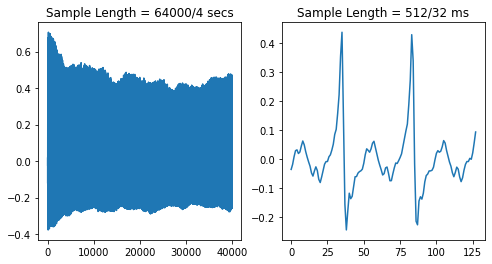

<ipython-input-10-7f078ff4c827>:80: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:137.)
  input_data = torch.cat((torch.from_numpy(input_pitch).view(1,-1).cuda(),\


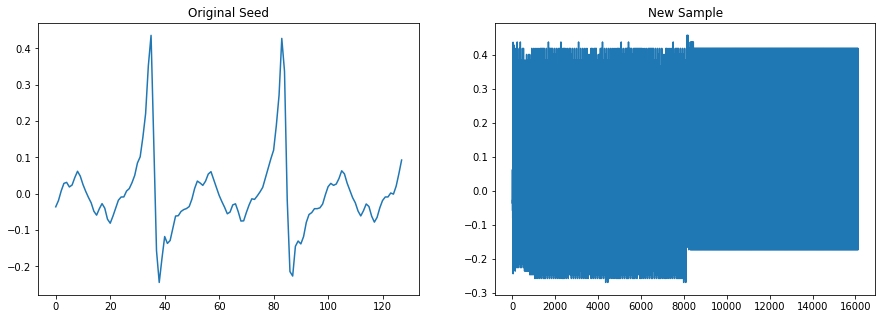

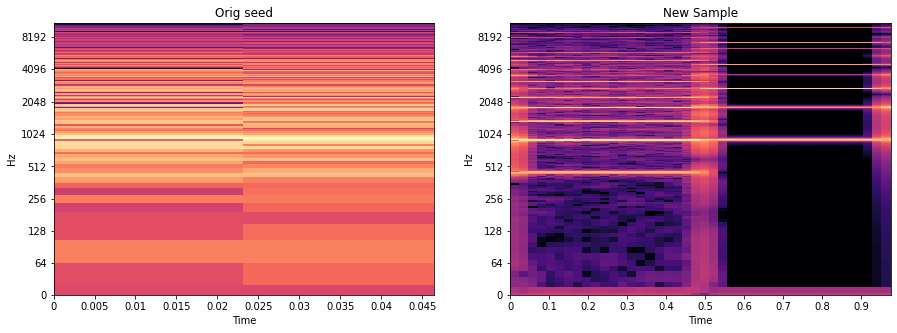

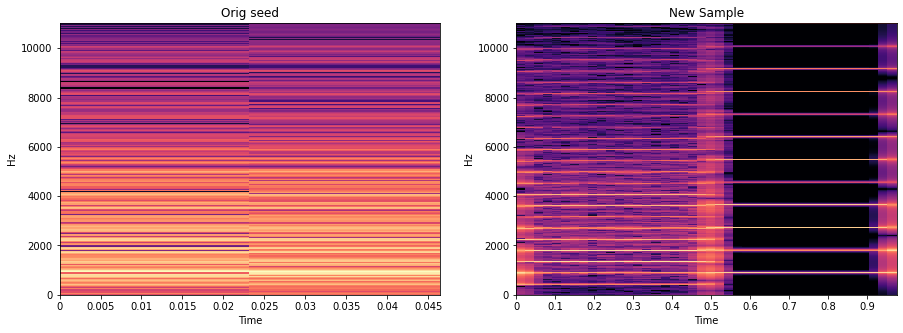

Time taken for sampling/plotting =  0:02:09


In [12]:
new_sample, orig_seed = sample_model_pitch_interpolation('brass_acoustic_018-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=0, seq_len=16000, interpolation_type='step')

brass_acoustic_018-064-a.90


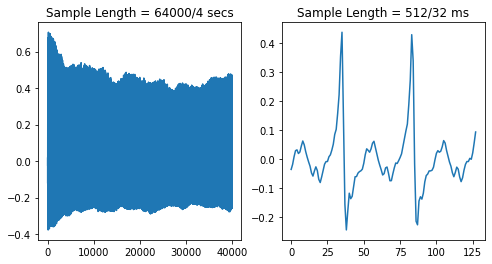

0 64.00075
2000 65.50074999999295
4000 67.0007499999859
6000 68.50074999997885
8000 70.0007499999718
10000 71.50074999996475
12000 73.0007499999577
14000 74.50074999995066


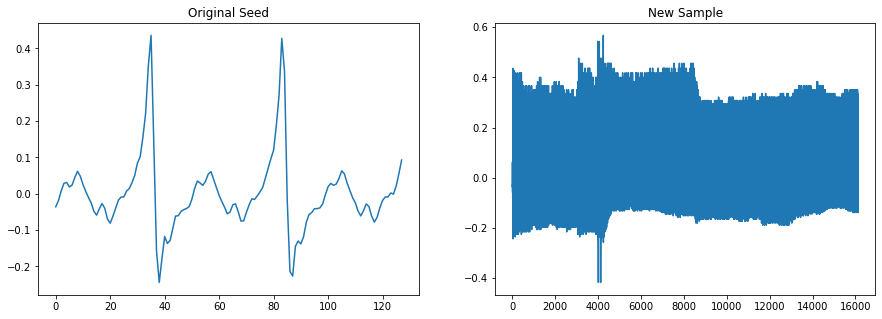

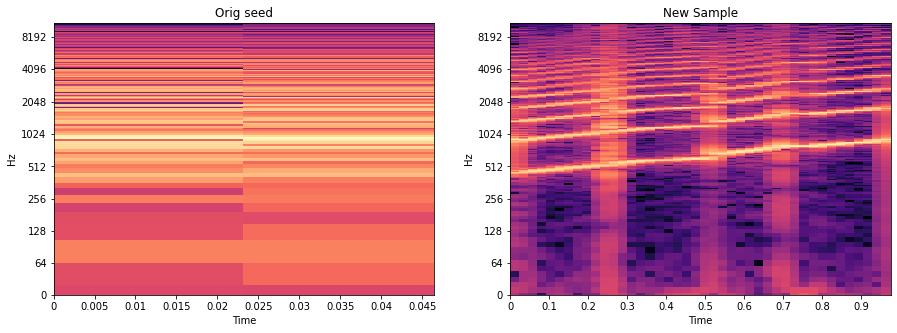

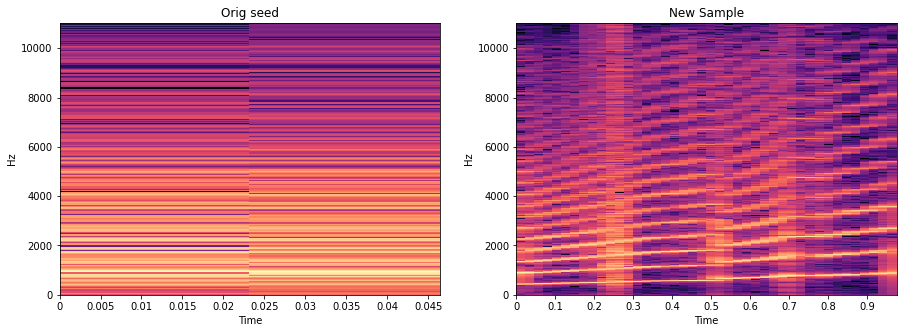

Time taken for sampling/plotting =  0:02:28


In [13]:
new_sample, orig_seed = sample_model_pitch_interpolation('brass_acoustic_018-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=0, seq_len=16000, interpolation_type='continuous')

brass_acoustic_018-064-a.90


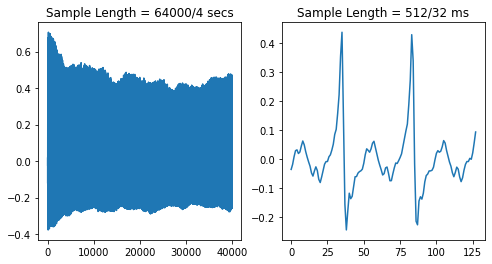

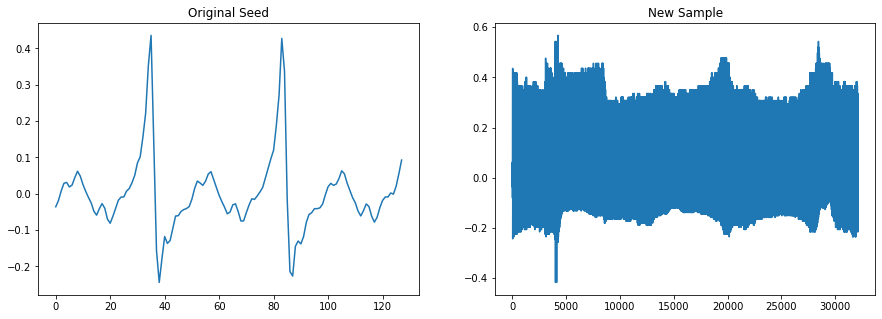

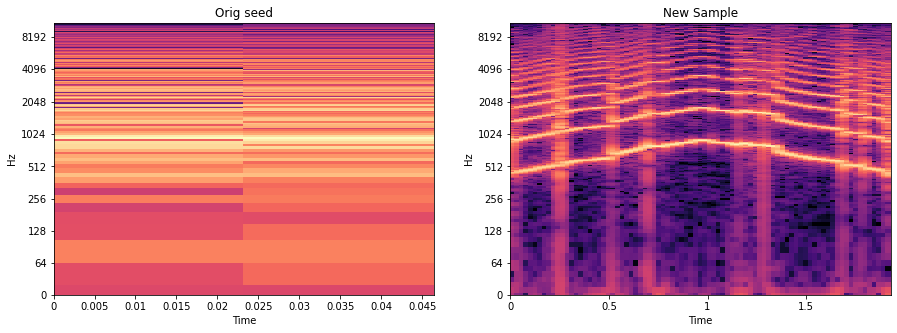

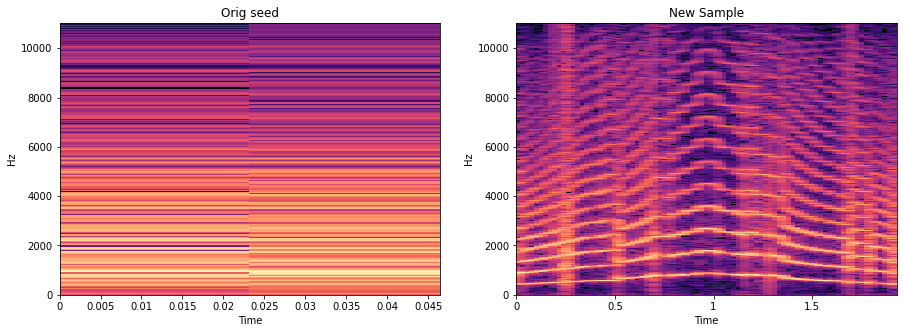

Time taken for sampling/plotting =  0:05:06


In [14]:
new_sample, orig_seed = sample_model_pitch_interpolation('brass_acoustic_018-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=0, seq_len=32000, interpolation_type='triangles')

brass_acoustic_018-064-a.90


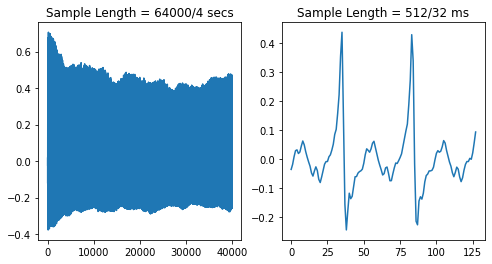

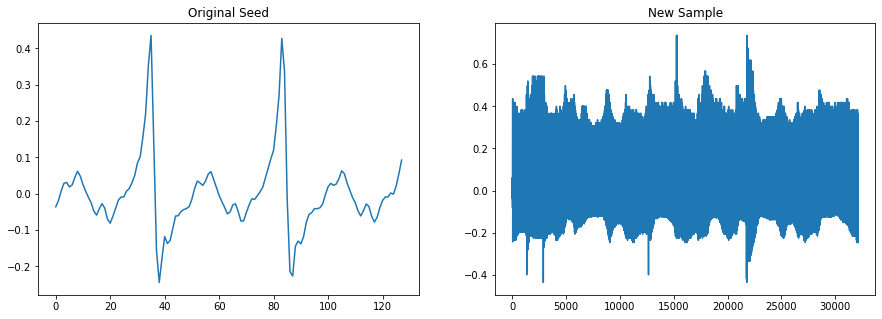

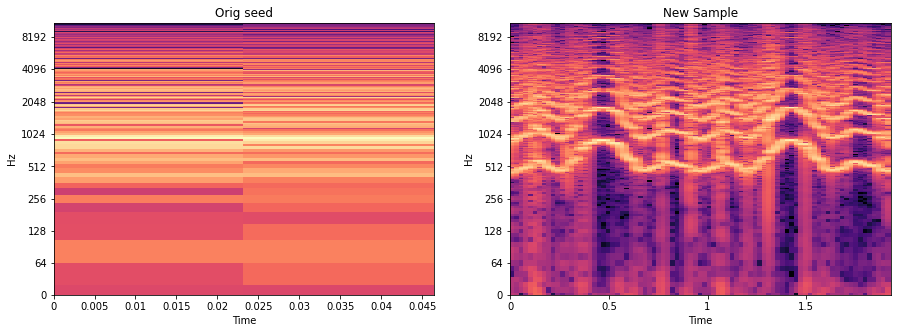

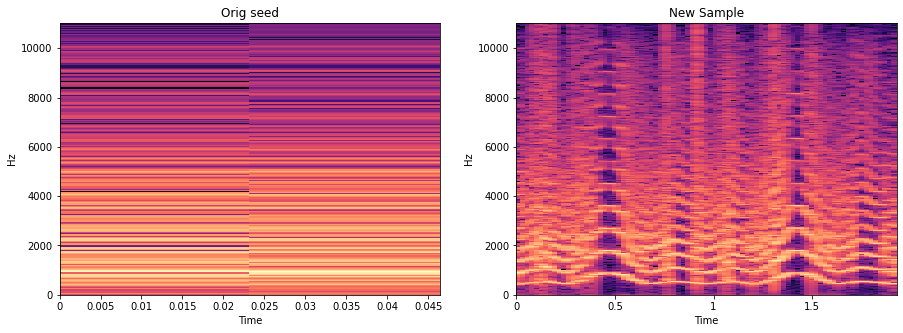

Time taken for sampling/plotting =  0:05:06


In [15]:
new_sample, orig_seed = sample_model_pitch_interpolation('brass_acoustic_018-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=0, seq_len=32000, interpolation_type='triangles-2')

## Reed

reed_acoustic_000-064-a.90


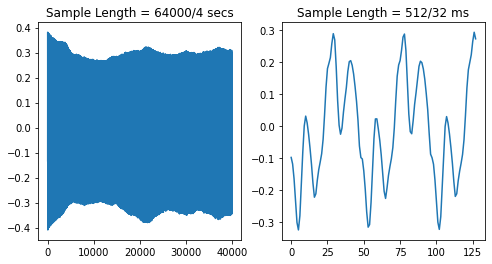

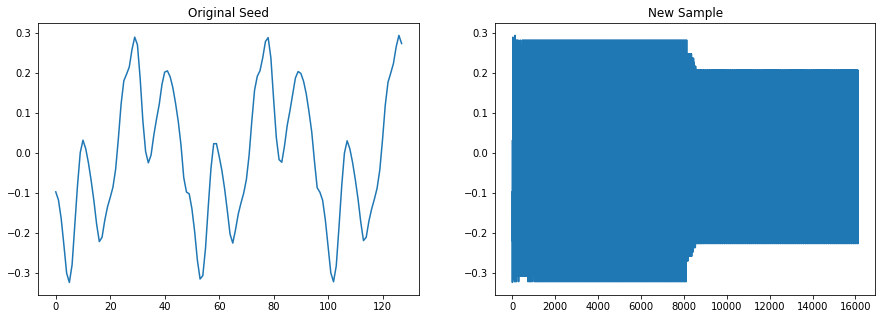

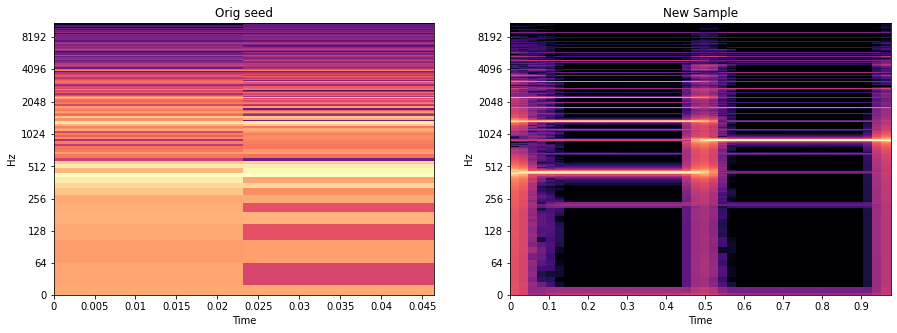

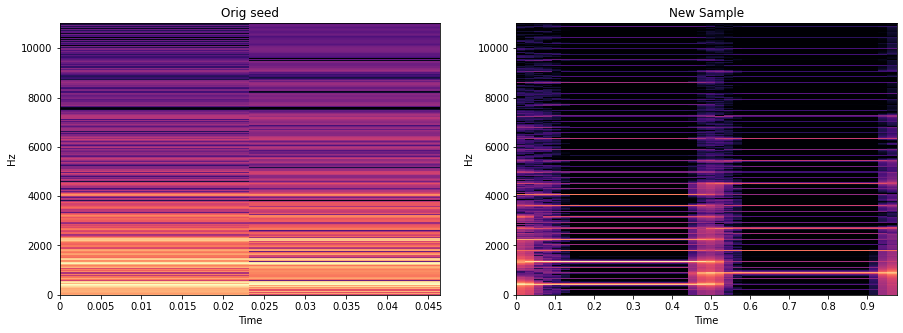

Time taken for sampling/plotting =  0:02:33


In [16]:
new_sample, orig_seed = sample_model_pitch_interpolation('reed_acoustic_000-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=16000, interpolation_type='step')

reed_acoustic_000-064-a.90


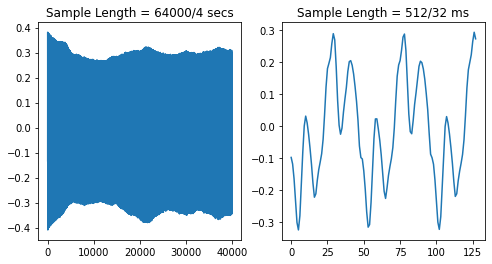

0 64.00075
2000 65.50074999999295
4000 67.0007499999859
6000 68.50074999997885
8000 70.0007499999718
10000 71.50074999996475
12000 73.0007499999577
14000 74.50074999995066


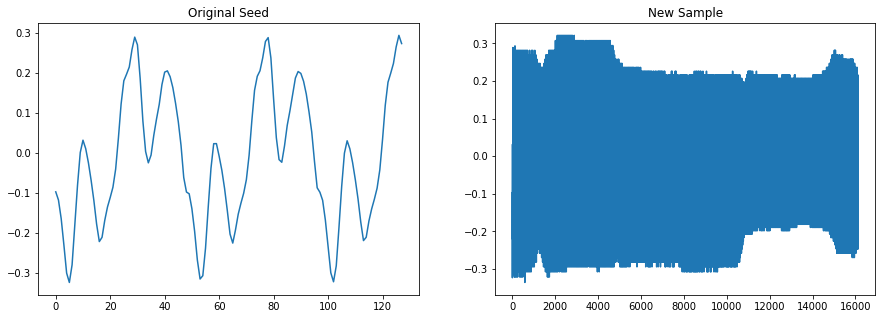

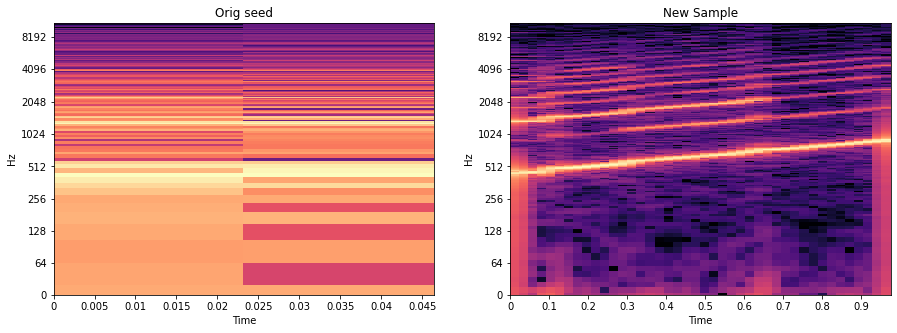

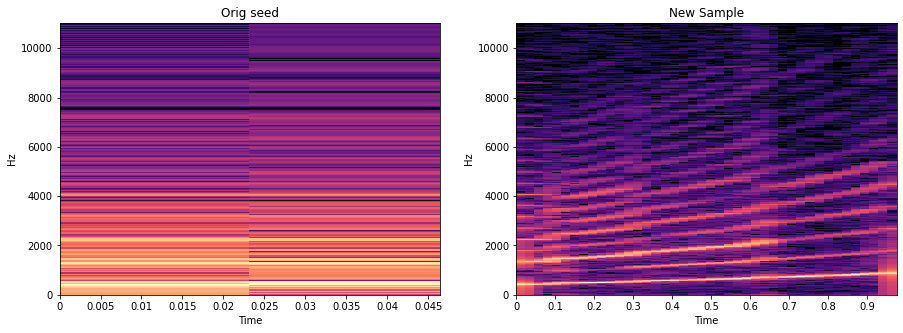

Time taken for sampling/plotting =  0:02:33


In [17]:
new_sample, orig_seed = sample_model_pitch_interpolation('reed_acoustic_000-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=16000, interpolation_type='continuous')

reed_acoustic_000-064-a.90


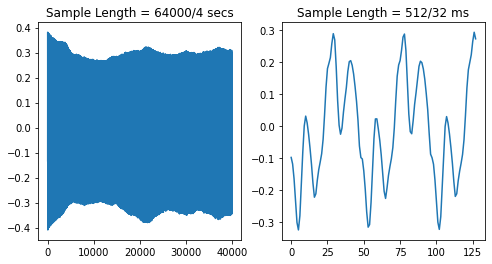

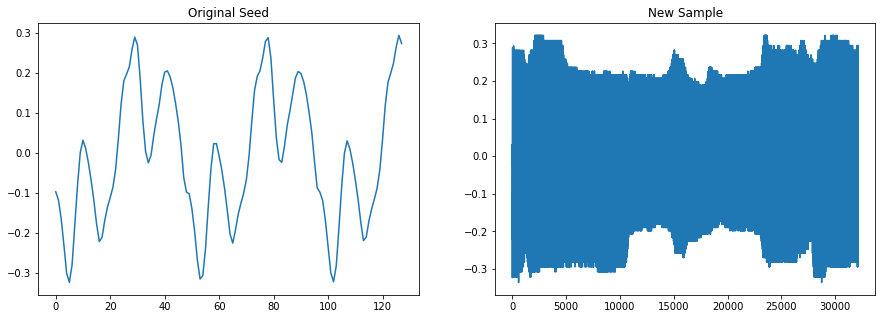

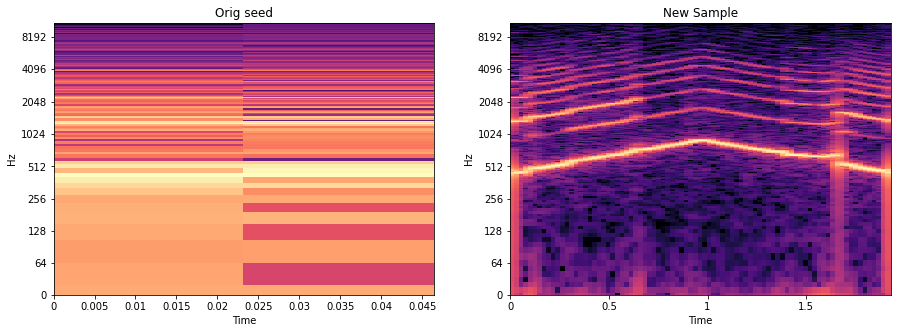

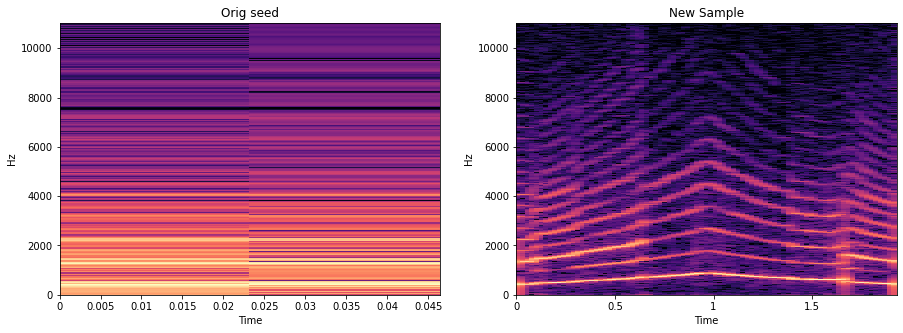

Time taken for sampling/plotting =  0:05:05


In [18]:
new_sample, orig_seed = sample_model_pitch_interpolation('reed_acoustic_000-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=32000, interpolation_type='triangles')

reed_acoustic_000-064-a.90


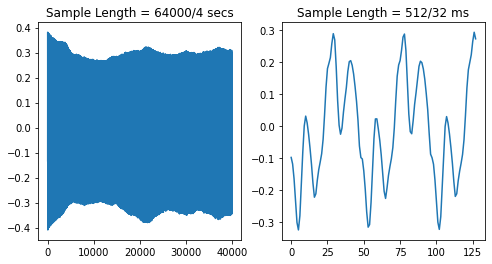

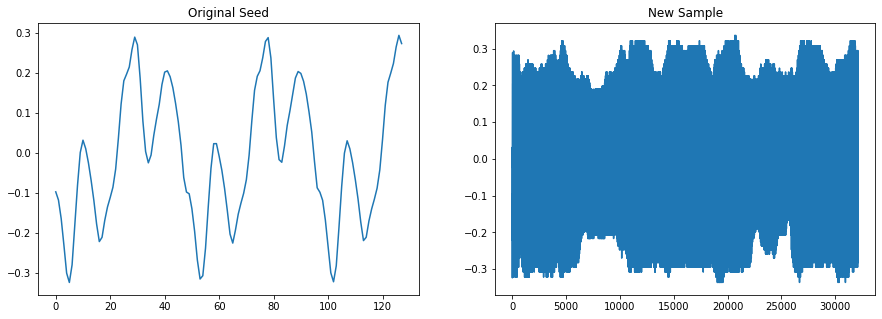

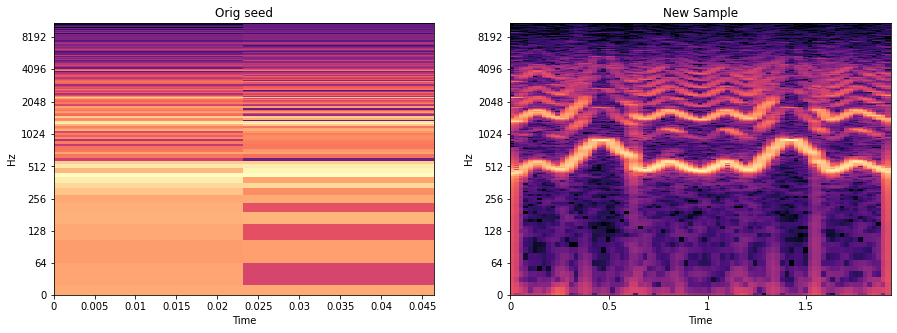

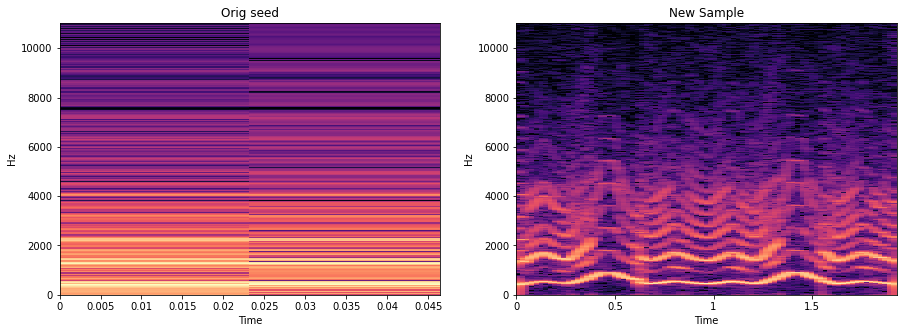

Time taken for sampling/plotting =  0:05:06


In [19]:
new_sample, orig_seed = sample_model_pitch_interpolation('reed_acoustic_000-064-a.90', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=32000, interpolation_type='triangles-2')

## Zero/Random Pitch

brass_acoustic_018-064-a.0


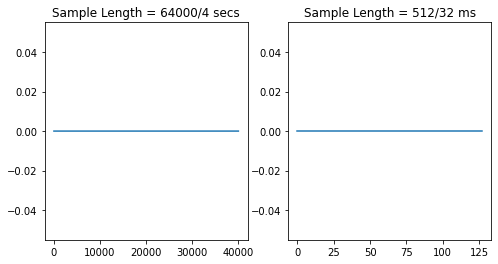

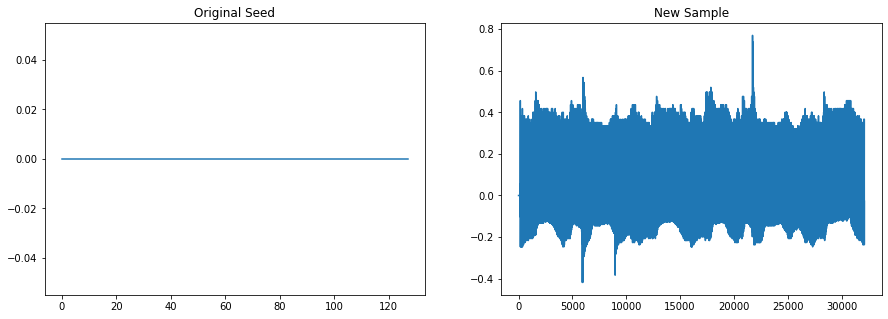

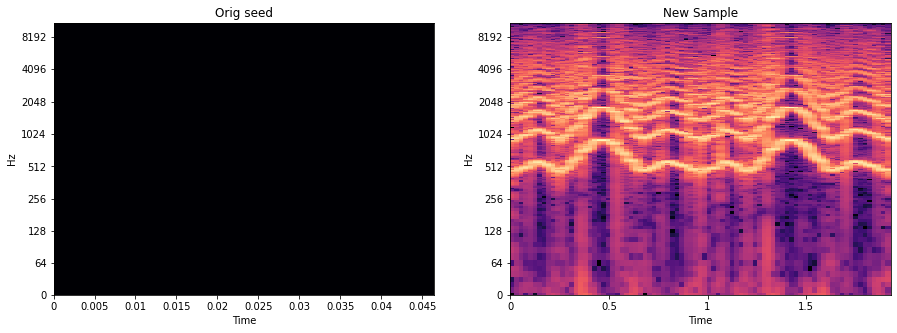

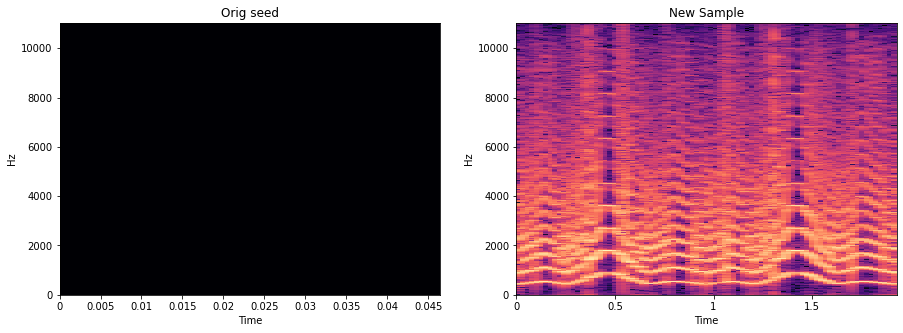

Time taken for sampling/plotting =  0:05:05


In [20]:
new_sample, orig_seed = sample_model_pitch_interpolation('brass_acoustic_018-064-a.0', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=0, seq_len=32000, interpolation_type='triangles-2')

random


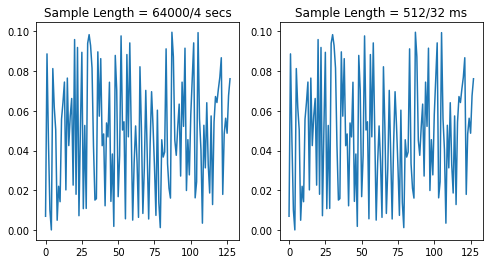

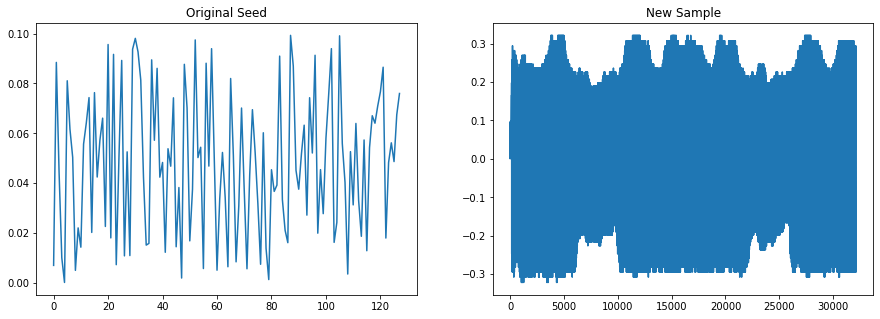

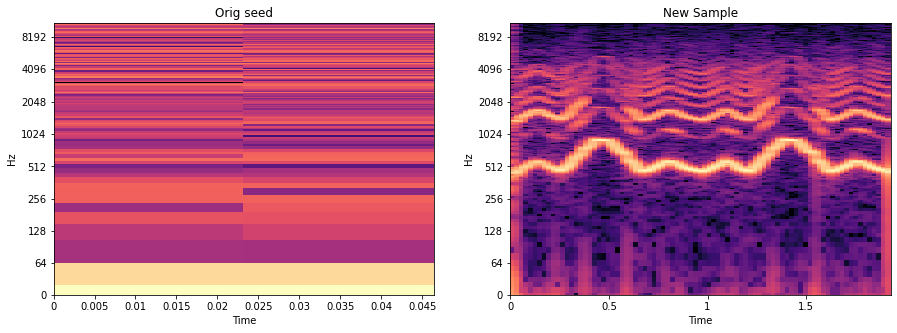

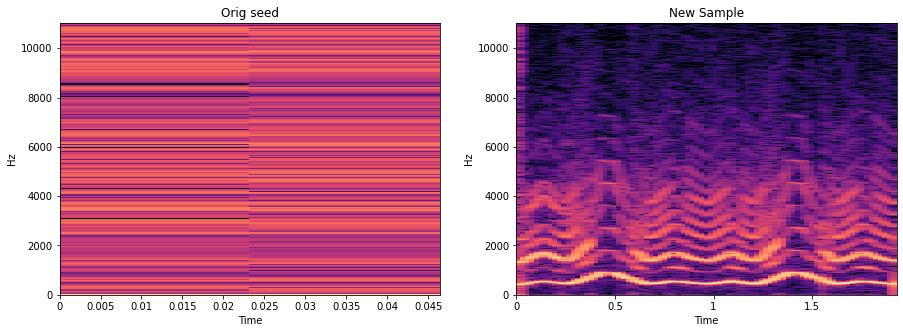

Time taken for sampling/plotting =  0:05:08


In [21]:
new_sample, orig_seed = sample_model_pitch_interpolation('random', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.9, \
                                     instrument_id=1, seq_len=32000, interpolation_type='triangles-2')

## Intrument Interpolation - Brass(0) to Reed (1)

brass_acoustic_018-070-a.0


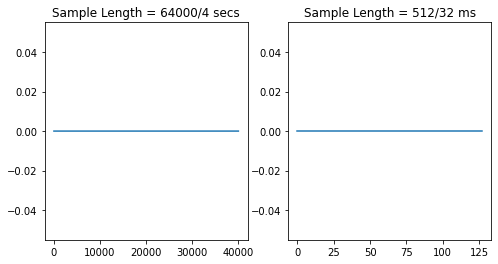

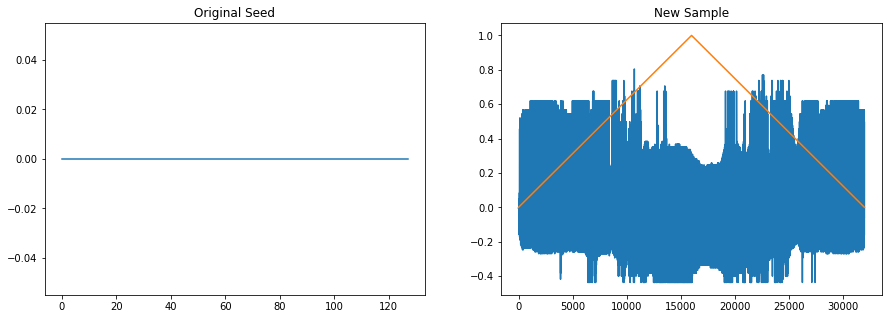

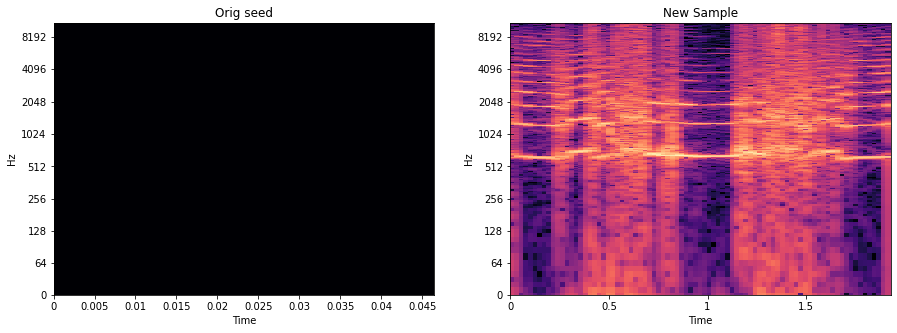

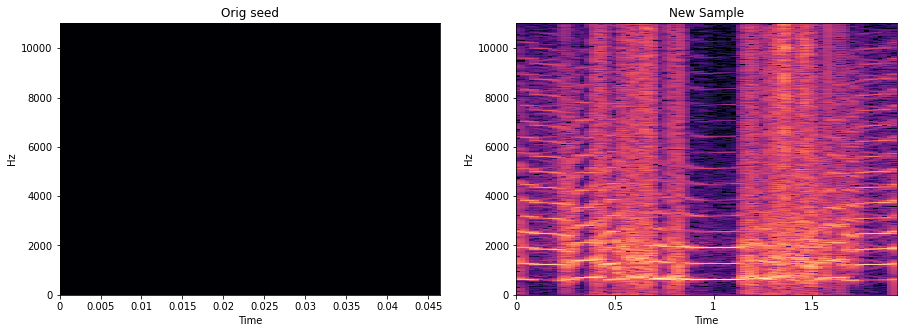

Time taken for sampling/plotting =  0:05:05


In [22]:
new_sample, orig_seed = sample_model_instrument_interpolation('brass_acoustic_018-070-a.0', model_interp=model_interp, start_location=1, pitch=70, amplitude_scale=0.9, \
                                     instrument_id=0, seq_len=32000, interpolation_type='triangles')

## Amplitude Interpolation

reed_acoustic_000-064-a.10


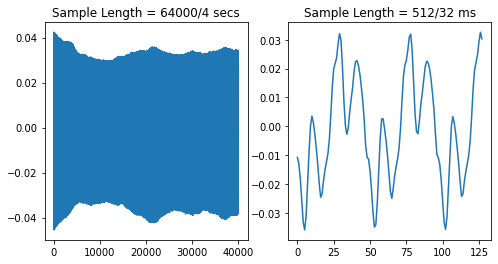

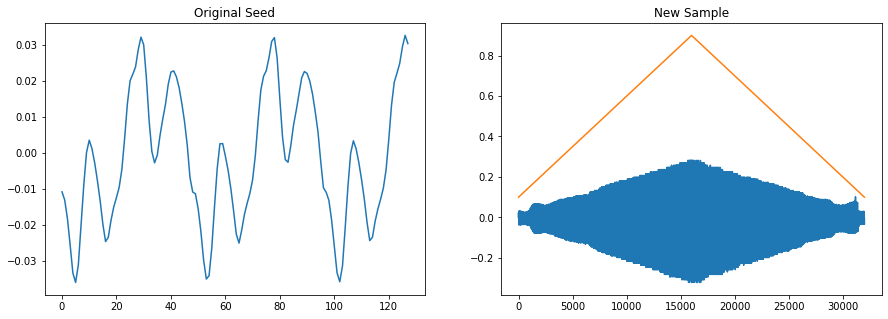

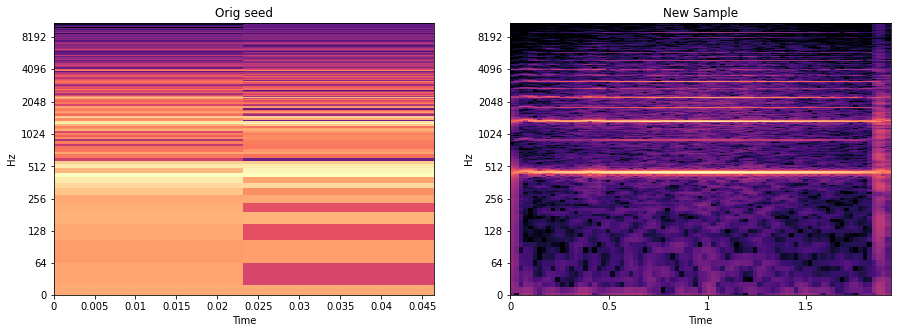

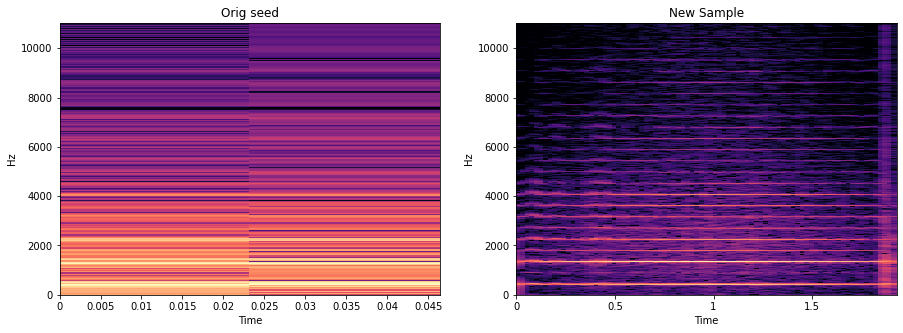

Time taken for sampling/plotting =  0:05:07


In [23]:
new_sample, orig_seed = sample_model_amplitude_interpolation('reed_acoustic_000-064-a.10', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.1, \
                                     instrument_id=1, seq_len=2*16000, interpolation_type='triangles')

brass_acoustic_018-064-a.10


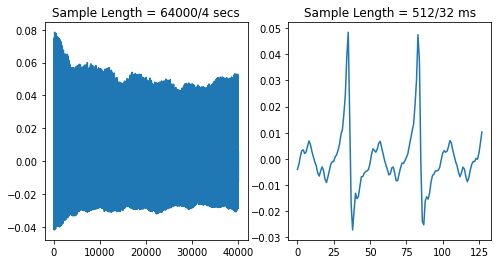

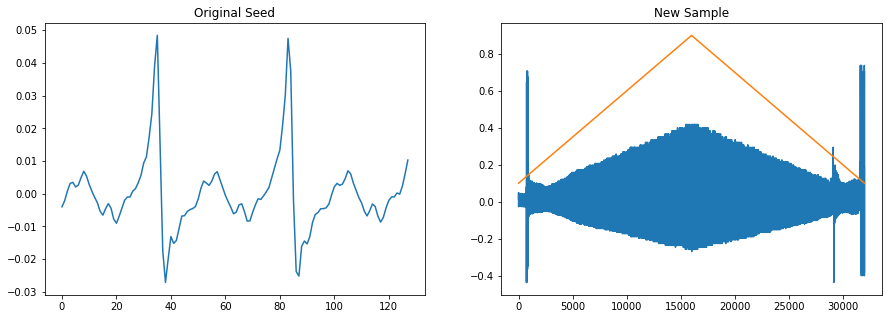

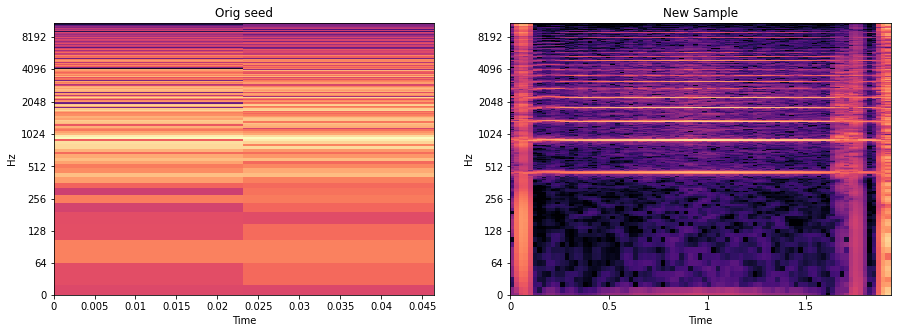

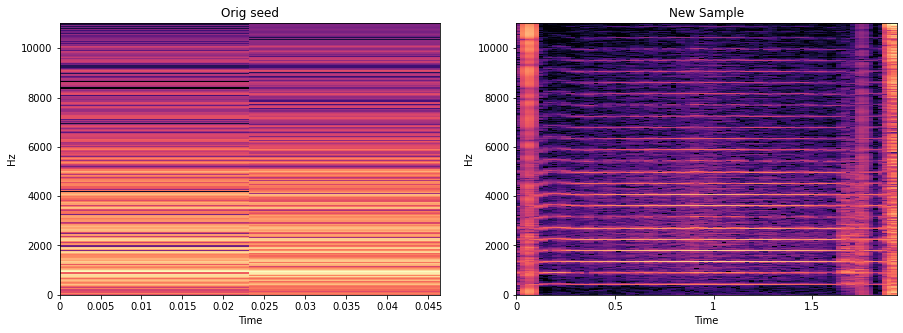

Time taken for sampling/plotting =  0:04:52


In [24]:
new_sample, orig_seed = sample_model_amplitude_interpolation('brass_acoustic_018-064-a.10', model_interp=model_interp, start_location=1, pitch=64, amplitude_scale=0.1, \
                                     instrument_id=0, seq_len=2*16000, interpolation_type='triangles')